# Experiment

## Install Python dependencies

Import the dependencies for the model training code:

In [2]:
import numpy as np
import pandas as pd
import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import tf2onnx
import onnx
import pickle
from pathlib import Path

## Load the CSV data

The CSV data that you use to train the model contains the following fields:

* **distancefromhome** - The distance from home where the transaction happened.
* **distancefromlast_transaction** - The distance from the last transaction that happened.
* **ratiotomedianpurchaseprice** - The ratio of purchased price compared to median purchase price.
* **repeat_retailer** - If it's from a retailer that already has been purchased from before.
* **used_chip** - If the credit card chip was used.
* **usedpinnumber** - If the PIN number was used.
* **online_order** - If it was an online order.
* **fraud** - If the transaction is fraudulent.

In [3]:
# Set the input (X) and output (Y) data. 
# The only output data is whether it's fraudulent. All other fields are inputs to the model.

feature_indexes = [
    1,  # distance_from_last_transaction
    2,  # ratio_to_median_purchase_price
    4,  # used_chip
    5,  # used_pin_number
    6,  # online_order
]

label_indexes = [
    7  # fraud
]

X_train = pd.read_csv('data/train.csv')
y_train = X_train.iloc[:, label_indexes]
X_train = X_train.iloc[:, feature_indexes]

X_val = pd.read_csv('data/validate.csv')
y_val = X_val.iloc[:, label_indexes]
X_val = X_val.iloc[:, feature_indexes]

X_test = pd.read_csv('data/test.csv')
y_test = X_test.iloc[:, label_indexes]
X_test = X_test.iloc[:, feature_indexes]


# Scale the data to remove mean and have unit variance. The data will be between -1 and 1, which makes it a lot easier for the model to learn than random (and potentially large) values.
# It is important to only fit the scaler to the training data, otherwise you are leaking information about the global distribution of variables (which is influenced by the test set) into the training set.

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train.values)

Path("artifact").mkdir(parents=True, exist_ok=True)
with open("artifact/test_data.pkl", "wb") as handle:
    pickle.dump((X_test, y_test), handle)
with open("artifact/scaler.pkl", "wb") as handle:
    pickle.dump(scaler, handle)

# Since the dataset is unbalanced (it has many more non-fraud transactions than fraudulent ones), set a class weight to weight the few fraudulent transactions higher than the many non-fraud transactions.
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.values.ravel())
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

## Build the model

The model is a simple, fully-connected, deep neural network, containing three hidden layers and one output layer.

In [4]:
model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = len(feature_indexes)))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

## Train the model

Training a model is often the most time-consuming part of the machine learning process.  Large models can take multiple GPUs for days.  Expect the training on CPU for this very simple model to take a minute or more.

In [5]:
# Train the model and get performance
import os
import time

start = time.time()
epochs = 2
history = model.fit(X_train, y_train, epochs=epochs, \
                    validation_data=(scaler.transform(X_val.values),y_val), \
                    verbose = True, class_weight = class_weights)
end = time.time()
print(f"Training of model is complete. Took {end-start} seconds")

Epoch 1/2
18750/18750 [==============================] - 10s 509us/step - loss: 0.2619 - accuracy: 0.9263 - val_loss: 0.2423 - val_accuracy: 0.9425
Epoch 2/2
18750/18750 [==============================] - 10s 537us/step - loss: 0.2371 - accuracy: 0.9474 - val_loss: 0.1983 - val_accuracy: 0.9564
Training of model is complete. Took 20.165951013565063 seconds


## Save the model file

In [6]:
# Save the model as ONNX for easy use of ModelMesh
model_proto, _ = tf2onnx.convert.from_keras(model)
os.makedirs("models/fraud/1", exist_ok=True)
onnx.save(model_proto, "models/fraud/1/model.onnx")

## Confirm the model file was created successfully

The output should include the model name, size, and date. 

In [7]:
! ls -alRh ./models/

total 0
drwxr-xr-x@  3 cchase  staff    96B Aug 19 11:42 .
drwxr-xr-x  30 cchase  staff   960B Aug 19 11:45 ..
drwxr-xr-x@  3 cchase  staff    96B Aug 19 11:42 fraud

./models//fraud:
total 0
drwxr-xr-x@ 3 cchase  staff    96B Aug 19 11:42 .
drwxr-xr-x@ 3 cchase  staff    96B Aug 19 11:42 ..
drwxr-xr-x@ 3 cchase  staff    96B Aug 19 11:42 1

./models//fraud/1:
total 32
drwxr-xr-x@ 3 cchase  staff    96B Aug 19 11:42 .
drwxr-xr-x@ 3 cchase  staff    96B Aug 19 11:42 ..
-rw-r--r--@ 1 cchase  staff    13K Aug 19 11:45 model.onnx


## Test the model

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pickle
import onnxruntime as rt

Load the test data and scaler:

In [9]:
with open('artifact/scaler.pkl', 'rb') as handle:
    scaler = pickle.load(handle)
with open('artifact/test_data.pkl', 'rb') as handle:
    (X_test, y_test) = pickle.load(handle)

Create an ONNX inference runtime session and predict values for all test inputs:

In [10]:
sess = rt.InferenceSession("models/fraud/1/model.onnx", providers=rt.get_available_providers())
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
y_pred_temp = sess.run([output_name], {input_name: scaler.transform(X_test.values).astype(np.float32)}) 
y_pred_temp = np.asarray(np.squeeze(y_pred_temp[0]))
threshold = 0.95
y_pred = np.where(y_pred_temp > threshold, 1, 0)

Show the results:

Eval Metrics: 
 Accuracy: 97.4%, Precision: 0.9938, Recall: 0.6999 



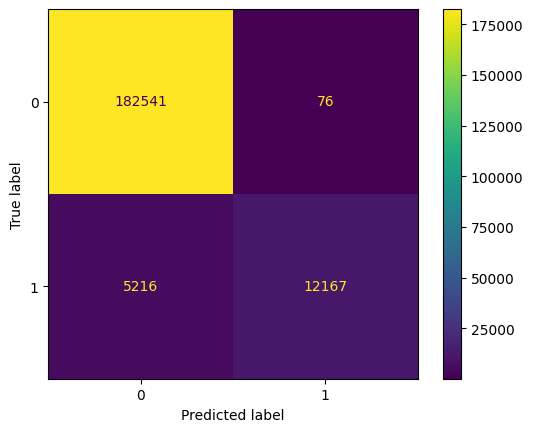

In [11]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_test_arr = y_test.to_numpy().squeeze()
correct = np.equal(y_pred, y_test_arr).sum().item()
acc = (correct / len(y_pred)) * 100
precision = precision_score(y_test_arr, np.round(y_pred))
recall = recall_score(y_test_arr, np.round(y_pred))

print(f"Eval Metrics: \n Accuracy: {acc:>0.1f}%, "
      f"Precision: {precision:.4f}, Recall: {recall:.4f} \n")

c_matrix = confusion_matrix(y_test_arr, y_pred)
ConfusionMatrixDisplay(c_matrix).plot()

## Example: Is Sally's transaction likely to be fraudulent?

Here is the order of the fields from Sally's transaction details:
* distance_from_last_transaction
* ratio_to_median_price
* used_chip 
* used_pin_number
* online_order 

In [12]:
sally_transaction_details = [
    [0.3111400080477545,
    1.9459399775518593, 
    1.0, 
    0.0, 
    0.0]
    ]

prediction = sess.run([output_name], {input_name: scaler.transform(sally_transaction_details).astype(np.float32)})

print("Is Sally's transaction predicted to be fraudulent? (true = YES, false = NO) ")
print(np.squeeze(prediction) > threshold)

print("How likely was Sally's transaction to be fraudulent? ")
print("{:.5f}".format(np.squeeze(prediction)) + "%")

Is Sally's transaction predicted to be fraudulent? (true = YES, false = NO) 
False
How likely was Sally's transaction to be fraudulent? 
0.00002%
